In [1]:
from difflogic import PairedLogicLayer, InvLogicLayer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
)

# Make the dataset only 0s and 1s
# mnist_train.data = mnist_train.data[np.where((mnist_train.targets == 1) | (mnist_train.targets == 0))]
# mnist_train.targets = mnist_train.targets[np.where((mnist_train.targets == 1) | (mnist_train.targets == 0))]
# mnist_test.data = mnist_test.data[np.where((mnist_test.targets == 1) | (mnist_test.targets == 0))]
# mnist_test.targets = mnist_test.targets[np.where((mnist_test.targets == 1) | (mnist_test.targets == 0))]

# make the label 1 vs all classifier
mnist_train.targets = (mnist_train.targets == 1).int()
mnist_test.targets = (mnist_test.targets == 1).int()

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

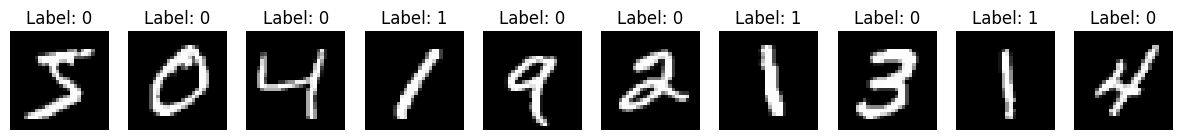

In [3]:
# Visualize the dataset
def visualize_dataset(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(dataset.data[i].numpy(), cmap='gray')
        axes[i].set_title(f"Label: {dataset.targets[i]}")
        axes[i].axis('off')
    plt.show()

visualize_dataset(mnist_train)

In [4]:
class AndLogicLayer(nn.Module):
    def __init__(self):
        super(AndLogicLayer, self).__init__()
    
    def forward(self, x):
        sum = torch.sum(x, dim=1)
        # calculate mean of list
        mean = 400.0
        # calculate std of list
        std = 11.0
        # calculate output
        output = torch.sigmoid((sum - mean) / std)
        return output

class GhostNet(nn.Module):
    def __init__(self):
        super(GhostNet, self).__init__()
        self.ghost_image = torch.zeros(28*28).unsqueeze(0).to('cuda')
        self.invert = InvLogicLayer(int(28*28), int(28*28), restricted_gates=[3,12], implementation='python')
        self.xor = PairedLogicLayer(int(28*28*2), int(28*28), restricted_gates=[6], implementation='python')
        self.and_gate = AndLogicLayer()
    def forward(self, x): 
        y = x.squeeze(1).reshape(-1, 28*28).to('cuda')
        z = self.invert(self.ghost_image.repeat((y.shape[0], 1)))
        z = self.xor(torch.cat((y, z), dim=1))
        z = self.and_gate(z)
        return z

In [5]:
net = GhostNet()

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data.to('cuda'))
        loss = loss_fn(output, target.to('cuda').float())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
            if batch_idx == 0:
                plt.imshow(data[0].squeeze(), cmap='gray')
                plt.title(f'Target: {target[0]}')
                plt.show()
                plt.imshow(net.ghost_image.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('Ghost Image')
                plt.show()
                plt.imshow(net.invert(net.ghost_image).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('Inverted Ghost Image')
                plt.show()
                plt.imshow(net.xor(torch.cat((net.invert(net.ghost_image), data[0].to('cuda').reshape((1, -1))), dim=1)).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('XOR Output')
                plt.show()
                # Print AND output
                print('AND Output:')
                print(net.and_gate(net.xor(torch.cat((net.invert(net.ghost_image), data[0].to('cuda').reshape((1, -1))), dim=1))).squeeze().detach())

def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data.to('cuda'))
            test_loss += loss_fn(output, target.to('cuda').float()).item()
            pred = output.round()
            correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

Train Epoch: 1 [0/60000] Loss: 0.520059


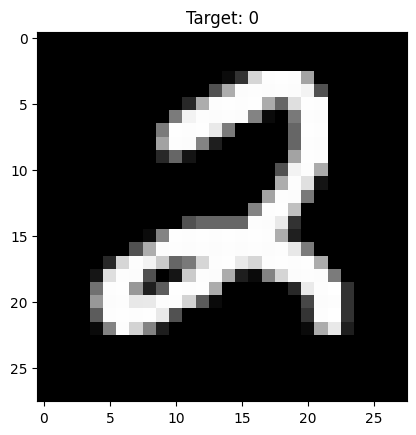

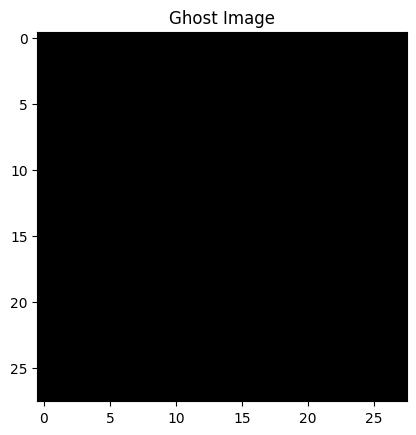

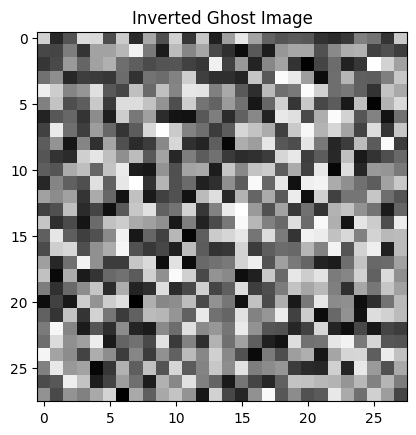

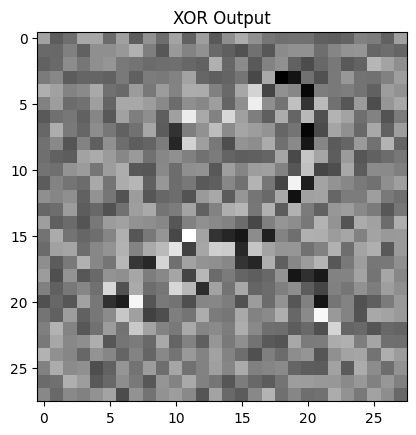

AND Output:
tensor(0.1497, device='cuda:0')
Train Epoch: 1 [6400/60000] Loss: 0.342005
Train Epoch: 1 [12800/60000] Loss: 0.183039
Train Epoch: 1 [19200/60000] Loss: 0.196316
Train Epoch: 1 [25600/60000] Loss: 0.191268
Train Epoch: 1 [32000/60000] Loss: 0.155928
Train Epoch: 1 [38400/60000] Loss: 0.158366
Train Epoch: 1 [44800/60000] Loss: 0.151568
Train Epoch: 1 [51200/60000] Loss: 0.063712
Train Epoch: 1 [57600/60000] Loss: 0.123971
Test set: Average loss: 0.0013, Accuracy: 9702/10000 (97%)
Train Epoch: 2 [0/60000] Loss: 0.066302


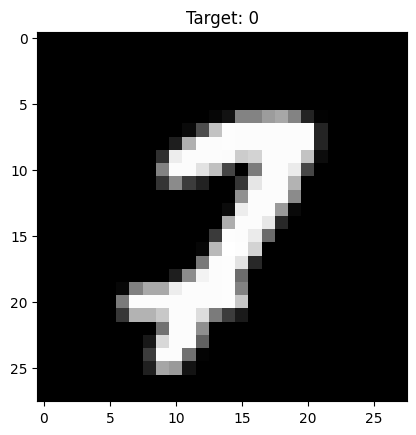

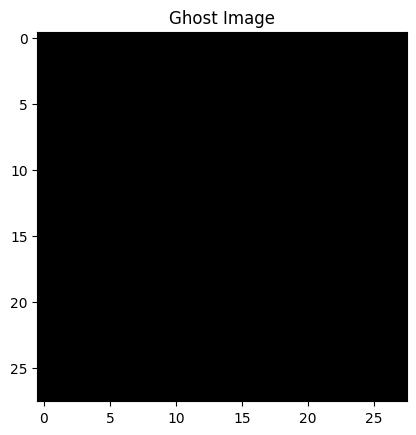

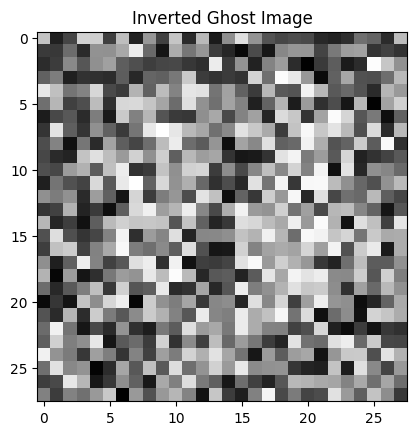

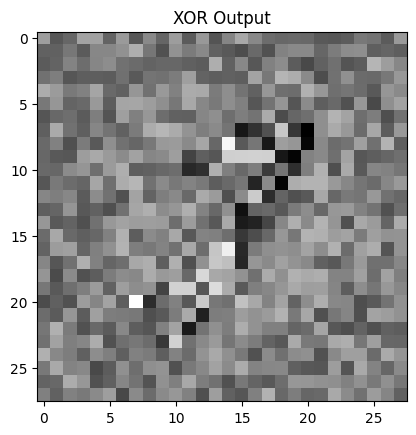

AND Output:
tensor(0.0482, device='cuda:0')
Train Epoch: 2 [6400/60000] Loss: 0.061176
Train Epoch: 2 [12800/60000] Loss: 0.116026
Train Epoch: 2 [19200/60000] Loss: 0.058800
Train Epoch: 2 [25600/60000] Loss: 0.100323
Train Epoch: 2 [32000/60000] Loss: 0.055665
Train Epoch: 2 [38400/60000] Loss: 0.161715
Train Epoch: 2 [44800/60000] Loss: 0.048970
Train Epoch: 2 [51200/60000] Loss: 0.078147
Train Epoch: 2 [57600/60000] Loss: 0.073463
Test set: Average loss: 0.0007, Accuracy: 9846/10000 (98%)
Train Epoch: 3 [0/60000] Loss: 0.029636


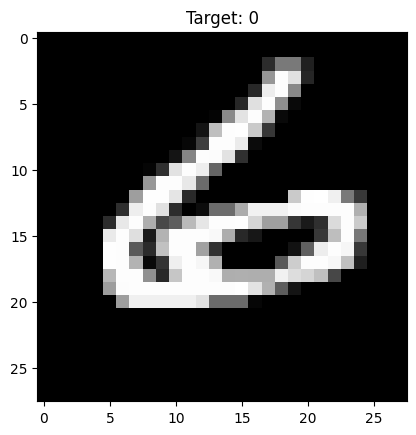

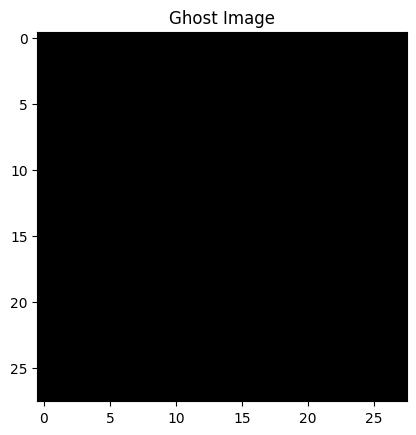

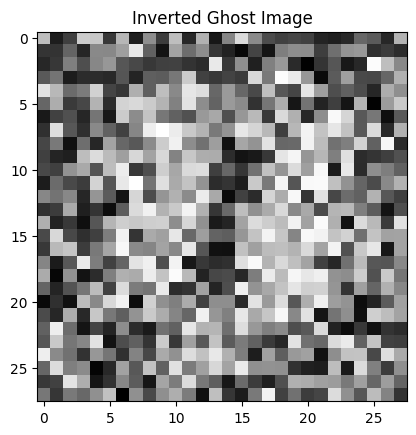

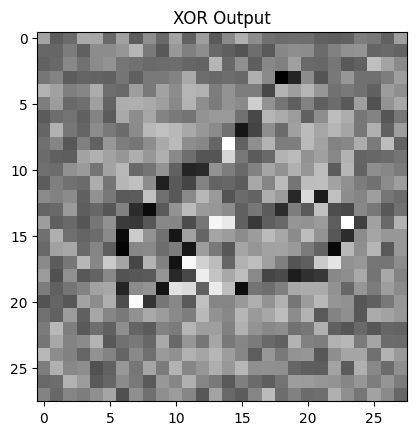

AND Output:
tensor(0.0017, device='cuda:0')
Train Epoch: 3 [6400/60000] Loss: 0.122928
Train Epoch: 3 [12800/60000] Loss: 0.077860
Train Epoch: 3 [19200/60000] Loss: 0.042049
Train Epoch: 3 [25600/60000] Loss: 0.090987
Train Epoch: 3 [32000/60000] Loss: 0.031735
Train Epoch: 3 [38400/60000] Loss: 0.038649
Train Epoch: 3 [44800/60000] Loss: 0.124700
Train Epoch: 3 [51200/60000] Loss: 0.100244
Train Epoch: 3 [57600/60000] Loss: 0.061068
Test set: Average loss: 0.0006, Accuracy: 9854/10000 (99%)
Train Epoch: 4 [0/60000] Loss: 0.015032


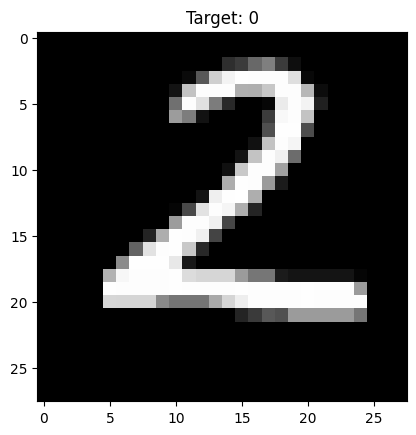

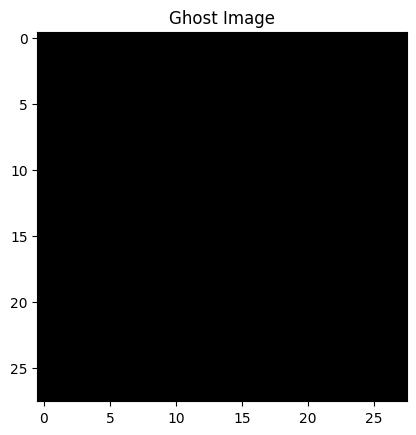

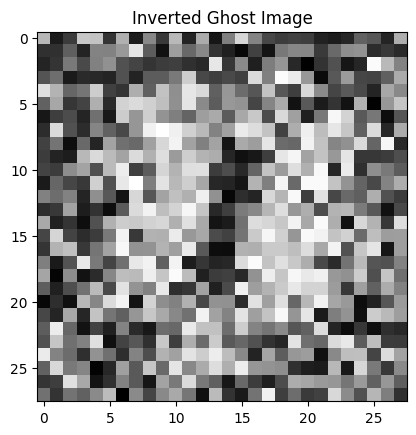

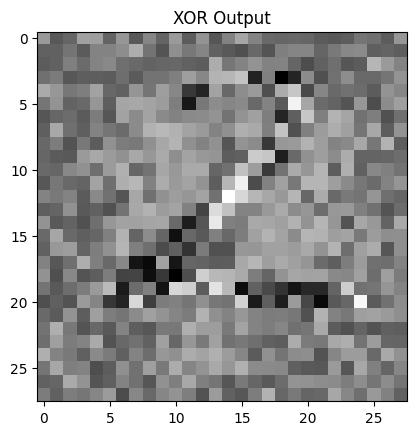

AND Output:
tensor(0.0157, device='cuda:0')
Train Epoch: 4 [6400/60000] Loss: 0.028381
Train Epoch: 4 [12800/60000] Loss: 0.059313
Train Epoch: 4 [19200/60000] Loss: 0.022158
Train Epoch: 4 [25600/60000] Loss: 0.034918
Train Epoch: 4 [32000/60000] Loss: 0.051186
Train Epoch: 4 [38400/60000] Loss: 0.038743
Train Epoch: 4 [44800/60000] Loss: 0.120445
Train Epoch: 4 [51200/60000] Loss: 0.060590
Train Epoch: 4 [57600/60000] Loss: 0.041637
Test set: Average loss: 0.0007, Accuracy: 9878/10000 (99%)
Train Epoch: 5 [0/60000] Loss: 0.029778


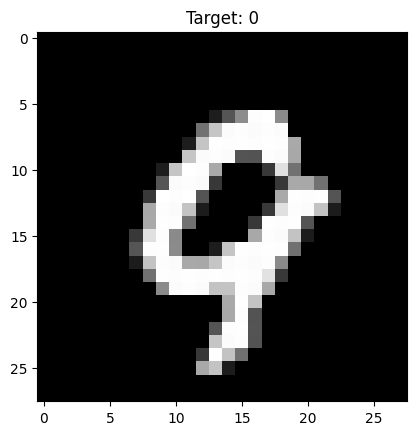

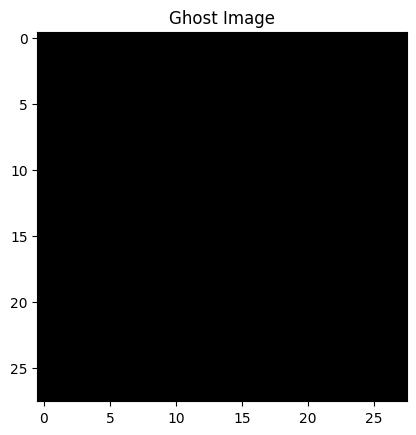

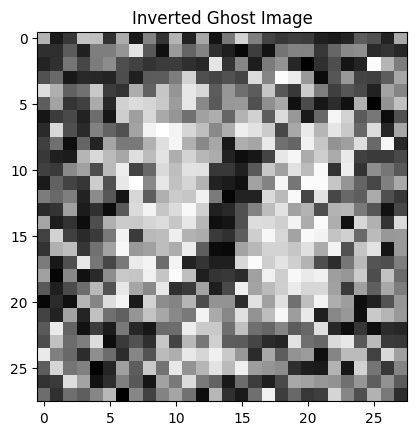

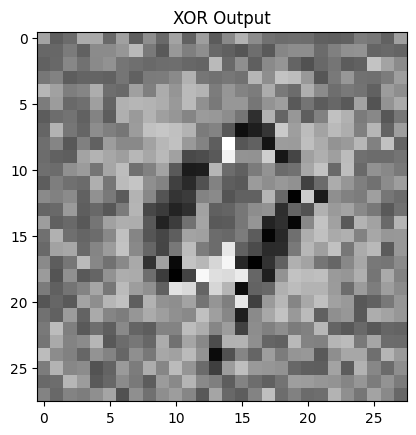

AND Output:
tensor(4.0060e-05, device='cuda:0')
Train Epoch: 5 [6400/60000] Loss: 0.044407
Train Epoch: 5 [12800/60000] Loss: 0.025952
Train Epoch: 5 [19200/60000] Loss: 0.027611
Train Epoch: 5 [25600/60000] Loss: 0.009494
Train Epoch: 5 [32000/60000] Loss: 0.118471
Train Epoch: 5 [38400/60000] Loss: 0.052695
Train Epoch: 5 [44800/60000] Loss: 0.022938
Train Epoch: 5 [51200/60000] Loss: 0.009123
Train Epoch: 5 [57600/60000] Loss: 0.032763
Test set: Average loss: 0.0007, Accuracy: 9870/10000 (99%)
Train Epoch: 6 [0/60000] Loss: 0.037674


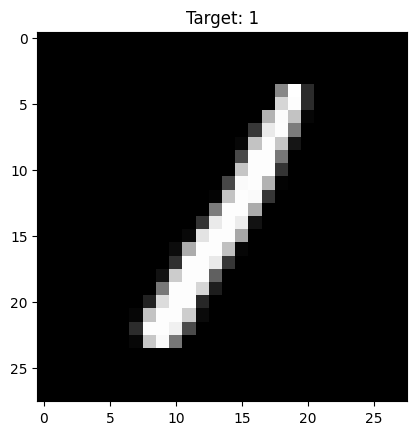

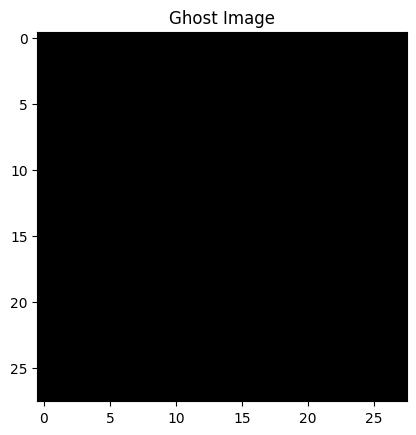

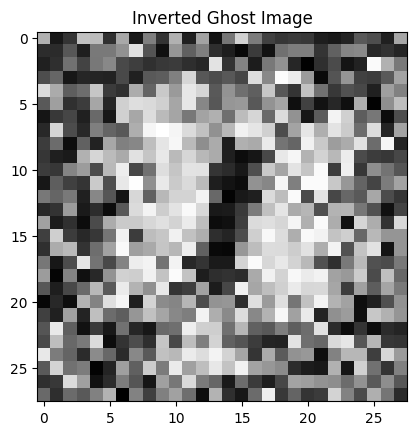

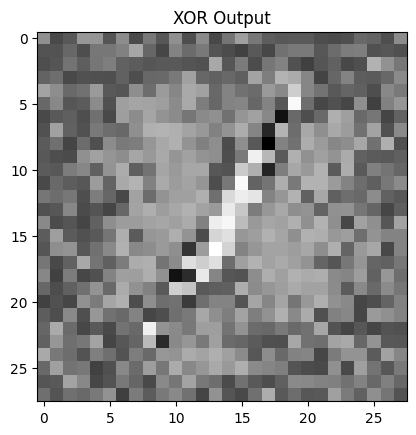

AND Output:
tensor(0.9677, device='cuda:0')
Train Epoch: 6 [6400/60000] Loss: 0.030757
Train Epoch: 6 [12800/60000] Loss: 0.013339
Train Epoch: 6 [19200/60000] Loss: 0.032863
Train Epoch: 6 [25600/60000] Loss: 0.049236
Train Epoch: 6 [32000/60000] Loss: 0.028791
Train Epoch: 6 [38400/60000] Loss: 0.031985
Train Epoch: 6 [44800/60000] Loss: 0.090450
Train Epoch: 6 [51200/60000] Loss: 0.074469
Train Epoch: 6 [57600/60000] Loss: 0.046199
Test set: Average loss: 0.0014, Accuracy: 9741/10000 (97%)
Train Epoch: 7 [0/60000] Loss: 0.056062


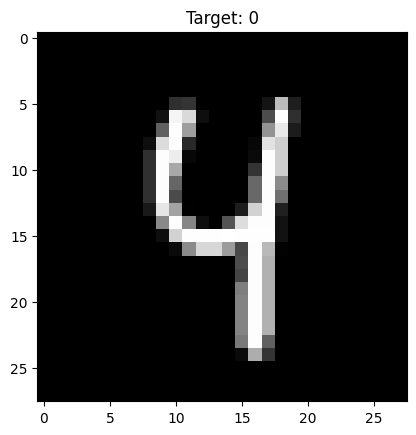

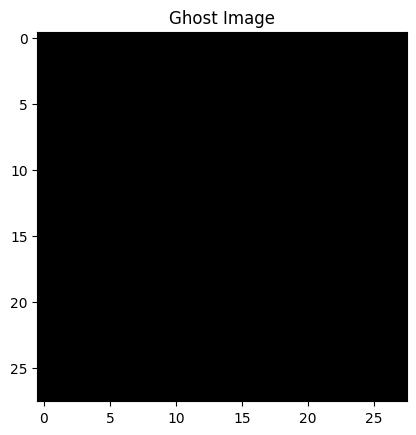

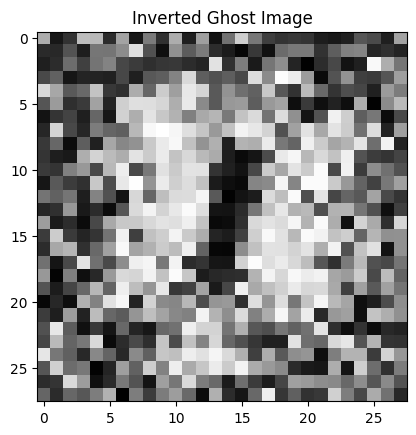

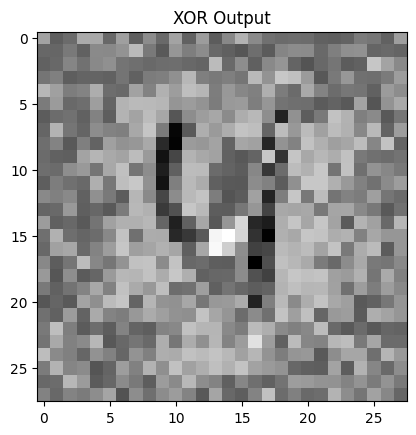

AND Output:
tensor(0.0016, device='cuda:0')
Train Epoch: 7 [6400/60000] Loss: 0.068073
Train Epoch: 7 [12800/60000] Loss: 0.142065
Train Epoch: 7 [19200/60000] Loss: 0.018636
Train Epoch: 7 [25600/60000] Loss: 0.008677
Train Epoch: 7 [32000/60000] Loss: 0.068537
Train Epoch: 7 [38400/60000] Loss: 0.038044
Train Epoch: 7 [44800/60000] Loss: 0.024702
Train Epoch: 7 [51200/60000] Loss: 0.069908
Train Epoch: 7 [57600/60000] Loss: 0.007328
Test set: Average loss: 0.0017, Accuracy: 9625/10000 (96%)
Train Epoch: 8 [0/60000] Loss: 0.033669


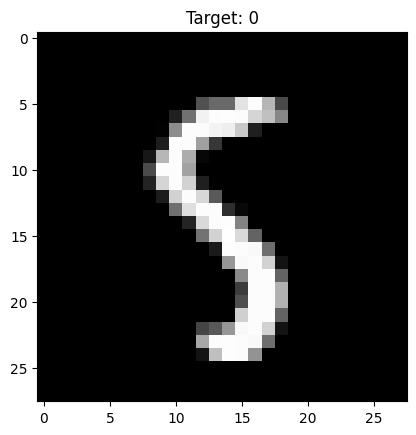

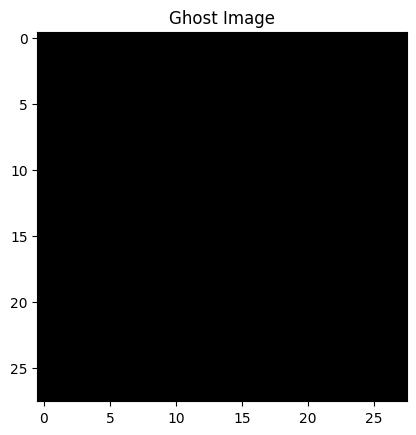

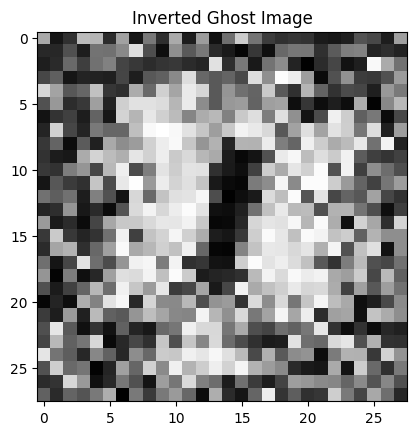

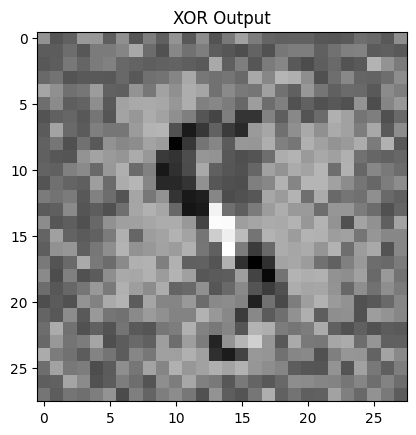

AND Output:
tensor(0.0016, device='cuda:0')
Train Epoch: 8 [6400/60000] Loss: 0.069909
Train Epoch: 8 [12800/60000] Loss: 0.021131
Train Epoch: 8 [19200/60000] Loss: 0.067976
Train Epoch: 8 [25600/60000] Loss: 0.009423
Train Epoch: 8 [32000/60000] Loss: 0.007926
Train Epoch: 8 [38400/60000] Loss: 0.005738
Train Epoch: 8 [44800/60000] Loss: 0.010018
Train Epoch: 8 [51200/60000] Loss: 0.068636
Train Epoch: 8 [57600/60000] Loss: 0.015792
Test set: Average loss: 0.0015, Accuracy: 9688/10000 (97%)
Train Epoch: 9 [0/60000] Loss: 0.016310


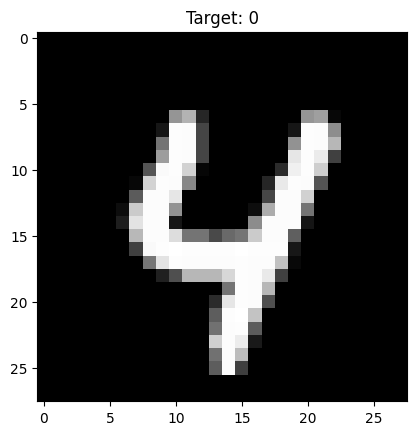

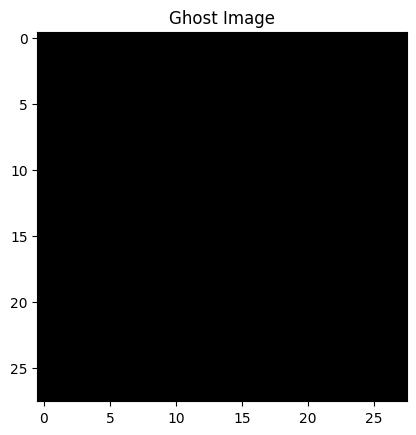

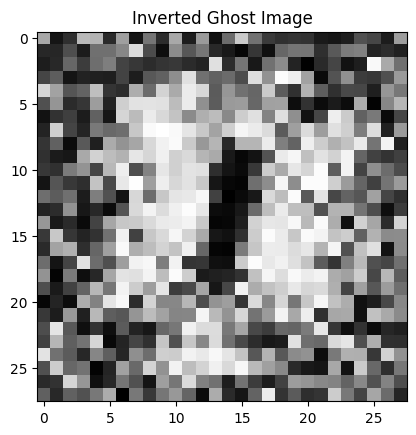

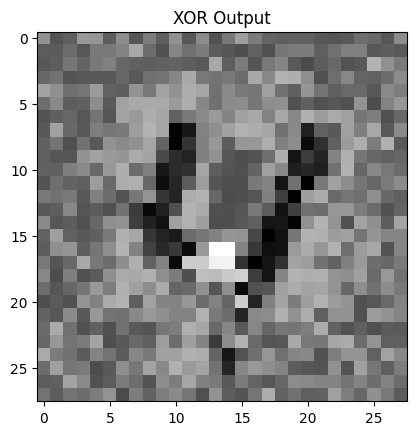

AND Output:
tensor(1.0048e-06, device='cuda:0')
Train Epoch: 9 [6400/60000] Loss: 0.142308
Train Epoch: 9 [12800/60000] Loss: 0.027029
Train Epoch: 9 [19200/60000] Loss: 0.020431
Train Epoch: 9 [25600/60000] Loss: 0.011501
Train Epoch: 9 [32000/60000] Loss: 0.070282
Train Epoch: 9 [38400/60000] Loss: 0.030446
Train Epoch: 9 [44800/60000] Loss: 0.045842
Train Epoch: 9 [51200/60000] Loss: 0.020679
Train Epoch: 9 [57600/60000] Loss: 0.017244
Test set: Average loss: 0.0013, Accuracy: 9713/10000 (97%)
Train Epoch: 10 [0/60000] Loss: 0.021811


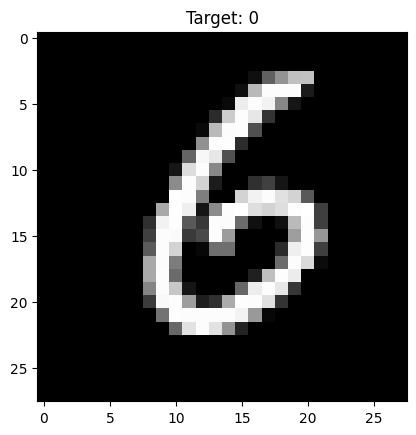

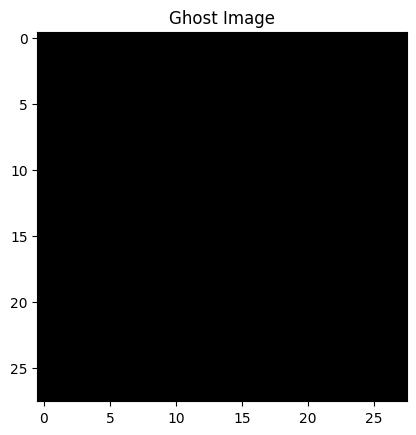

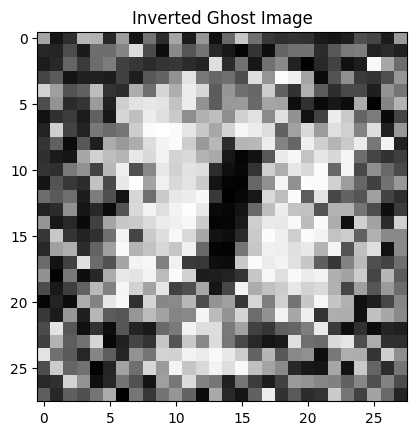

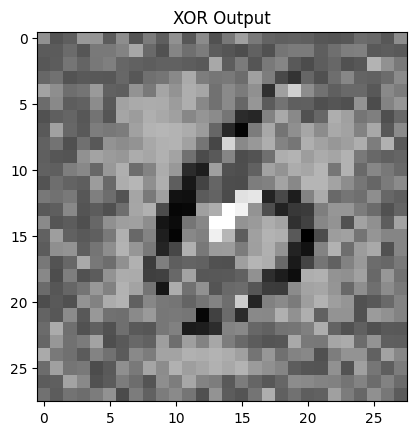

AND Output:
tensor(3.8027e-05, device='cuda:0')
Train Epoch: 10 [6400/60000] Loss: 0.013623
Train Epoch: 10 [12800/60000] Loss: 0.118498
Train Epoch: 10 [19200/60000] Loss: 0.023512
Train Epoch: 10 [25600/60000] Loss: 0.021992
Train Epoch: 10 [32000/60000] Loss: 0.041235
Train Epoch: 10 [38400/60000] Loss: 0.050675
Train Epoch: 10 [44800/60000] Loss: 0.038978
Train Epoch: 10 [51200/60000] Loss: 0.022398
Train Epoch: 10 [57600/60000] Loss: 0.026375
Test set: Average loss: 0.0013, Accuracy: 9748/10000 (97%)


In [6]:
for epoch in range(1, 11):
    train(epoch)
    test()

torch.Size([64, 1, 28, 28])
torch.Size([64])
Element: 2
Target: tensor(1)


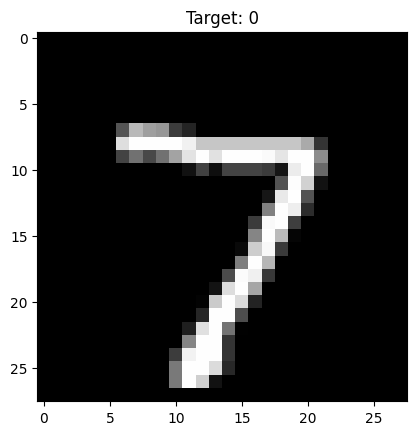

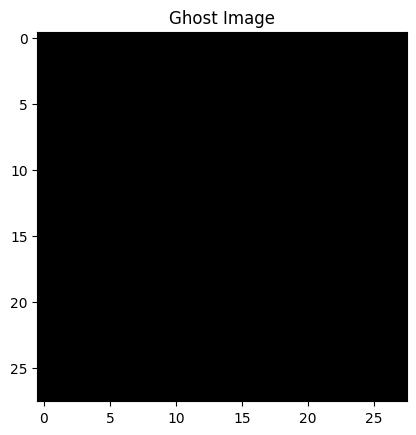

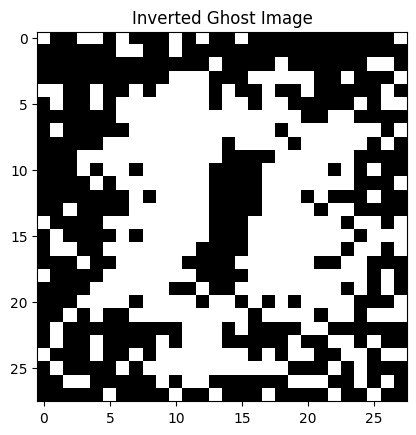

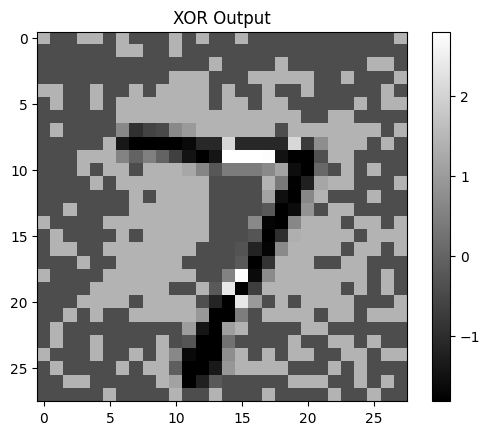

AND Output:
tensor(7.5904e-08, device='cuda:0')


In [7]:
(data, target) = next(iter(test_loader))
print(data.shape)
print(target.shape)

# Get a datapoint that is of class 1
for i in range(len(data)):
    if target[i] == 1:
        element = i
        break
print('Element:', element)
print('Target:', target[element])
element=0
net.eval()
plt.imshow(data[element].squeeze(), cmap='gray')
plt.title(f'Target: {target[element]}')
plt.show()
plt.imshow(net.ghost_image.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('Ghost Image')
plt.show()
plt.imshow(net.invert(net.ghost_image).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('Inverted Ghost Image')
plt.show()
xor = net.xor(torch.cat((data[element].to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
# xor = net.xor(torch.cat((torch.ones(28*28).to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
# Keep all values below the threshold, and set the rest to 0
# threshold = 1.8
# thresholded_xor = torch.absolute(torch.where(torch.absolute(xor) > threshold, xor, torch.tensor(threshold).to('cuda')))
plt.imshow(xor.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('XOR Output')
plt.colorbar()
plt.show()

# Print AND output
print('AND Output:')
print(net.and_gate(xor).squeeze().detach())

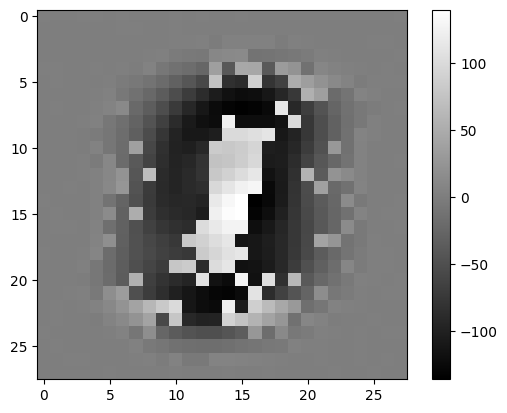

In [8]:
# Get the xor output for all the data in the dataset
net.eval()
data = train_loader.dataset.data
xor_outputs = []
for i in range(len(data)):
    xor = net.xor(torch.cat((data[i].to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
    xor_outputs.append(xor.cpu().squeeze().detach().reshape((28, 28)))
xor_outputs = torch.stack(xor_outputs)
# Plot the average of the xor outputs
avg_xor_output = torch.mean(xor_outputs, dim=0)
plt.imshow(avg_xor_output, cmap='gray')
plt.colorbar()